In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [166]:
import os
os.chdir('/content/drive/MyDrive/data science/marketprophecy-main/NSE Data')

In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,ridge_regression,Lasso
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM,Dense

In [168]:
data= pd.read_csv('NSE Training Data - 1st Jan 2016 to 1st Jan 2022.csv')
test=pd.read_csv('NSE Out of Time Testing Data - 1st Jan 2022 to 4th Feb 2022.csv')

In [169]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,7924.549805,7937.549805,7781.100098,7791.299805,7791.299805,134700.0
1,2016-01-05,7828.399902,7831.200195,7763.250000,7784.649902,7784.649902,145200.0
2,2016-01-06,7788.049805,7800.950195,7721.200195,7741.000000,7741.000000,147100.0
3,2016-01-07,7673.350098,7674.950195,7556.600098,7568.299805,7568.299805,188900.0
4,2016-01-08,7611.649902,7634.100098,7581.049805,7601.350098,7601.350098,157400.0


In [170]:
test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,17387.150391,17646.650391,17383.300781,17625.699219,17625.699219,200500
1,2022-01-04,17681.400391,17827.599609,17593.550781,17805.250000,17805.250000,247400
2,2022-01-05,17820.099609,17944.699219,17748.849609,17925.250000,17925.250000,251500
3,2022-01-06,17768.500000,17797.949219,17655.550781,17745.900391,17745.900391,236500
4,2022-01-07,17797.599609,17905.000000,17704.550781,17812.699219,17812.699219,239300


In [171]:
print(data.shape)
print(test.shape)

(1481, 7)
(23, 7)


In [172]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481 entries, 0 to 1480
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1481 non-null   object 
 1   Open       1475 non-null   float64
 2   High       1475 non-null   float64
 3   Low        1475 non-null   float64
 4   Close      1475 non-null   float64
 5   Adj Close  1475 non-null   float64
 6   Volume     1475 non-null   float64
dtypes: float64(6), object(1)
memory usage: 81.1+ KB


In [173]:
data.isnull().sum()

Date         0
Open         6
High         6
Low          6
Close        6
Adj Close    6
Volume       6
dtype: int64

In [174]:
test.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [175]:
data[data.isna().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume
151,2016-08-12,NaN,NaN,NaN,NaN,NaN,NaN
493,2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN
739,2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN
937,2019-10-27,NaN,NaN,NaN,NaN,NaN,NaN
1201,2020-11-14,NaN,NaN,NaN,NaN,NaN,NaN
1233,2021-01-01,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
data["Date"]=pd.to_datetime(data.Date,format="%Y-%m-%d")
data.index=data['Date']
test["Date"]=pd.to_datetime(test.Date,format="%Y-%m-%d")
test.index=test['Date']

In [180]:
data.dropna(inplace=True)
print(data.shape)
print(data.isnull().sum())

(1475, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


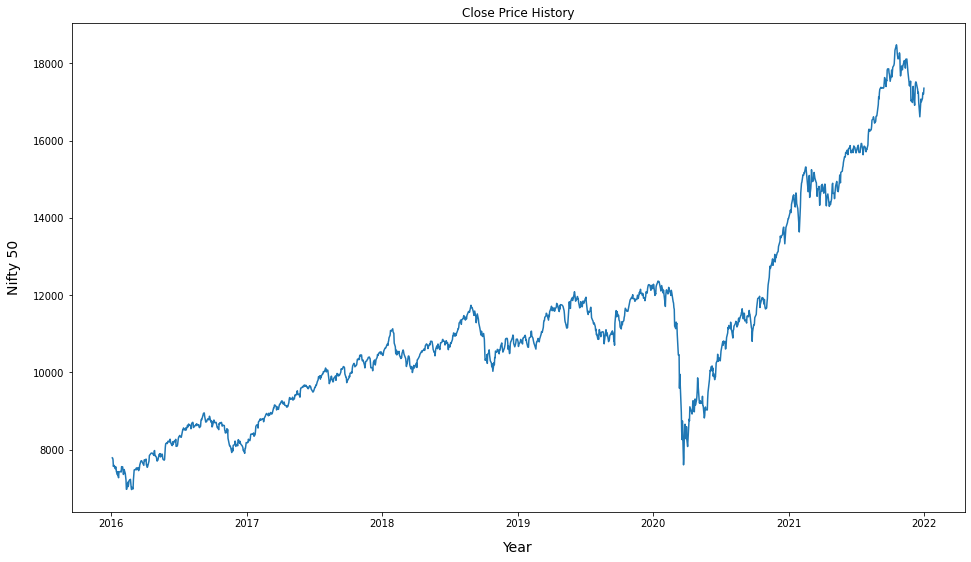

In [178]:
plt.figure(figsize=(16,9))
plt.plot(data['Close'])
plt.title('Close Price History')
plt.xlabel('Year',fontsize=14,labelpad=12)
plt.ylabel('Nifty 50',fontsize=14,labelpad=12)
plt.show()

###For test dataset we do not have 30 days previous data to calculate 30SMA lets get it from train data

In [181]:
previous_30_days= data.tail(30)
final_test=previous_30_days.append(test)

###Lets make few more features

In [182]:
#High low difference 
data['H-L']=data['High']-data['Low']
final_test['H-L']=final_test['High']-final_test['Low']

In [183]:
#stock close open difference
data['C-O']=data['Close']-data['Open']
#stock close open difference
final_test['C-O']=final_test['Close']-final_test['Open']

In [184]:
#Calculating Simple moving average(7,14,21,30) days for train also calculating std deviation
data['SMA7'] = data['Close'].rolling(7).mean()
data['SMA14'] = data['Close'].rolling(14).mean()
data['SMA21'] = data['Close'].rolling(21).mean()
data['SMA30'] = data['Close'].rolling(30).mean()

data['STD7'] = data['Close'].rolling(7).std()
data['STD14'] = data['Close'].rolling(14).std()
data['STD21'] = data['Close'].rolling(21).std()
data['STD30'] = data['Close'].rolling(30).std()

#Calculating Simple moving average(7,14,21,30) days for test also calculating std deviation

final_test['SMA7'] = final_test['Close'].rolling(7).mean()
final_test['SMA14'] = final_test['Close'].rolling(14).mean()
final_test['SMA21'] = final_test['Close'].rolling(21).mean()
final_test['SMA30'] = final_test['Close'].rolling(30).mean()

final_test['STD7'] = final_test['Close'].rolling(7).std()
final_test['STD14'] = final_test['Close'].rolling(14).std()
final_test['STD21'] = final_test['Close'].rolling(21).std()
final_test['STD30'] = final_test['Close'].rolling(30).std()


In [186]:
print(data.head())
print(final_test.head())

                 Date         Open         High  ...  STD14  STD21  STD30
Date                                             ...                     
2016-01-04 2016-01-04  7924.549805  7937.549805  ...    NaN    NaN    NaN
2016-01-05 2016-01-05  7828.399902  7831.200195  ...    NaN    NaN    NaN
2016-01-06 2016-01-06  7788.049805  7800.950195  ...    NaN    NaN    NaN
2016-01-07 2016-01-07  7673.350098  7674.950195  ...    NaN    NaN    NaN
2016-01-08 2016-01-08  7611.649902  7634.100098  ...    NaN    NaN    NaN

[5 rows x 17 columns]
                 Date          Open          High  ...  STD14  STD21  STD30
Date                                               ...                     
2021-11-22 2021-11-22  17796.250000  17805.250000  ...    NaN    NaN    NaN
2021-11-23 2021-11-23  17281.750000  17553.699219  ...    NaN    NaN    NaN
2021-11-24 2021-11-24  17550.050781  17600.599609  ...    NaN    NaN    NaN
2021-11-25 2021-11-25  17417.300781  17564.349609  ...    NaN    NaN    NaN
202

In [187]:
data.isnull().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
H-L           0
C-O           0
SMA7          6
SMA14        13
SMA21        20
SMA30        29
STD7          6
STD14        13
STD21        20
STD30        29
dtype: int64

In [84]:
# new_data=data.filter(['Close','Volume','H-L','C-O','SMA7','SMA14','SMA21','SMA30'])



In [189]:
data.Date = pd.to_datetime(data.Date, format="%Y-%m-%d")
data["month"] = data.Date.dt.month
data["day"] = data.Date.dt.day
data["day_of_week"] = data.Date.dt.dayofweek
data.head()



,Date,Open,High,Low,Close,Adj Close,Volume,H-L,C-O,SMA7,SMA14,SMA21,SMA30,STD7,STD14,STD21,STD30,month,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,
2016-01-04,2016-01-04,7924.549805,7937.549805,7781.100098,7791.299805,7791.299805,134700.0,156.449707,-133.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4,0
2016-01-05,2016-01-05,7828.399902,7831.200195,7763.250000,7784.649902,7784.649902,145200.0,67.950195,-43.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,5,1
2016-01-06,2016-01-06,7788.049805,7800.950195,7721.200195,7741.000000,7741.000000,147100.0,79.750000,-47.049805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6,2
2016-01-07,2016-01-07,7673.350098,7674.950195,7556.600098,7568.299805,7568.299805,188900.0,118.350097,-105.050293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7,3
2016-01-08,2016-01-08,7611.649902,7634.100098,7581.049805,7601.350098,7601.350098,157400.0,53.050293,-10.299804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,8,4


In [190]:
final_test.Date = pd.to_datetime(final_test.Date, format="%Y-%m-%d")
final_test["month"] = final_test.Date.dt.month
final_test["day"] = final_test.Date.dt.day
final_test["day_of_week"] = final_test.Date.dt.dayofweek
final_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume,H-L,C-O,SMA7,SMA14,SMA21,SMA30,STD7,STD14,STD21,STD30,month,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,
2021-11-22,2021-11-22,17796.250000,17805.250000,17280.449219,17416.550781,17416.550781,356400.0,524.800781,-379.699219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,22,0
2021-11-23,2021-11-23,17281.750000,17553.699219,17216.099609,17503.349609,17503.349609,308800.0,337.599610,221.599609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,23,1
2021-11-24,2021-11-24,17550.050781,17600.599609,17354.000000,17415.050781,17415.050781,298100.0,246.599609,-135.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,24,2
2021-11-25,2021-11-25,17417.300781,17564.349609,17351.699219,17536.250000,17536.250000,255900.0,212.650390,118.949219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,25,3
2021-11-26,2021-11-26,17338.750000,17355.400391,16985.699219,17026.449219,17026.449219,356300.0,369.701172,-312.300781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,26,4


In [191]:
col=['SMA7','SMA14','SMA21','SMA30','STD7','STD14','STD21','STD30']
for i in col:
  data[i].fillna(data['Adj Close'],inplace=True)

In [192]:
dataset=data[['Open', 'High', 'Low', 'Volume', 'Close',
                 'H-L','C-O', 'SMA7', 'SMA14', 'SMA21', 'SMA30', 
                 'STD7', 'STD14', 'STD21','STD30', 'month', 'day', 'day_of_week']]

test_dataset= final_test[['Open', 'High', 'Low', 'Volume', 'Close',
                 'H-L','C-O', 'SMA7', 'SMA14', 'SMA21', 'SMA30', 
                 'STD7', 'STD14', 'STD21','STD30', 'month', 'day', 'day_of_week']]

In [193]:
dataset.head()

,Open,High,Low,Volume,Close,H-L,C-O,SMA7,SMA14,SMA21,SMA30,STD7,STD14,STD21,STD30,month,day,day_of_week
Date,,,,,,,,,,,,,,,,,,
2016-01-04,7924.549805,7937.549805,7781.100098,134700.0,7791.299805,156.449707,-133.250000,7791.299805,7791.299805,7791.299805,7791.299805,7791.299805,7791.299805,7791.299805,7791.299805,1,4,0
2016-01-05,7828.399902,7831.200195,7763.250000,145200.0,7784.649902,67.950195,-43.750000,7784.649902,7784.649902,7784.649902,7784.649902,7784.649902,7784.649902,7784.649902,7784.649902,1,5,1
2016-01-06,7788.049805,7800.950195,7721.200195,147100.0,7741.000000,79.750000,-47.049805,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,1,6,2
2016-01-07,7673.350098,7674.950195,7556.600098,188900.0,7568.299805,118.350097,-105.050293,7568.299805,7568.299805,7568.299805,7568.299805,7568.299805,7568.299805,7568.299805,7568.299805,1,7,3
2016-01-08,7611.649902,7634.100098,7581.049805,157400.0,7601.350098,53.050293,-10.299804,7601.350098,7601.350098,7601.350098,7601.350098,7601.350098,7601.350098,7601.350098,7601.350098,1,8,4


In [197]:
test_x=test_dataset.tail(len(test_dataset)-30)
final_test_x=test_x.head(len(test_x)-1)
final_test_x.shape

(22, 18)

In [210]:
test_y=test_dataset.Close.tail(len(test_dataset)-30)
final_test_y=test_y.tail(len(test_y)-1)
final_test_y=np.array(final_test_y)
final_test_y

array([17805.25    , 17925.25    , 17745.900391, 17812.699219,
       18003.300781, 18055.75    , 18212.349609, 18257.800781,
       18255.75    , 18308.099609, 18113.050781, 17938.400391,
       17757.      , 17617.150391, 17149.099609, 17277.949219,
       17110.150391, 17101.949219, 17339.849609, 17576.849609,
       17780.      , 17560.199219])

In [218]:
y_train = dataset["Close"].tail(len(dataset)-1)
scaler=MinMaxScaler()
final_train_y=scaler.fit_transform(y_train.to_numpy().reshape(-1,1))
# final_train_y = dataset["Close"].to_numpy().reshape(-1,1)
print(final_train_y)
final_train_y.shape

[[0.07074726]
 [0.06695374]
 [0.05194475]
 ...
 [0.89019627]
 [0.88935758]
 [0.90240257]]


(1474, 1)

In [220]:
scaler_train=MinMaxScaler()
final_train_x=scaler_train.fit_transform(dataset.head(len(dataset)-1))
final_train_x.shape



#scaling test data
final_test_x=scaler_train.transform(final_test_x)
final_test_x


array([[0.89504873, 0.91721882, 0.90860193, 0.11071231, 0.92601093,
        0.15044146, 0.58490281, 0.90770872, 0.90540879, 0.91749773,
        0.92548394, 0.02395931, 0.028756  , 0.02909883, 0.02474066,
        0.        , 0.06666667, 0.        ],
       [0.92046178, 0.932858  , 0.92669651, 0.13660961, 0.94161529,
        0.13187727, 0.50672994, 0.91793261, 0.90917543, 0.92139758,
        0.92639446, 0.03151586, 0.0366025 , 0.03238944, 0.0271189 ,
        0.        , 0.1       , 0.25      ],
       [0.9324406 , 0.94297876, 0.94006187, 0.13887355, 0.95204422,
        0.10767527, 0.49398555, 0.92863486, 0.91354205, 0.92466659,
        0.92793321, 0.03698358, 0.04461575, 0.0373172 , 0.03081328,
        0.        , 0.13333333, 0.5       ],
       [0.92798418, 0.93029536, 0.93203237, 0.13059083, 0.93645735,
        0.07381004, 0.40691796, 0.93517421, 0.91844963, 0.92587258,
        0.9285655 , 0.03598316, 0.04727337, 0.03916554, 0.03210131,
        0.        , 0.16666667, 0.75      ],
    

#Linear Regression

In [223]:
linear=LinearRegression()
linear.fit(final_train_x,final_train_y)
predictions= linear.predict(final_test_x) 
predictions

array([[0.92754832],
       [0.94177693],
       [0.95198585],
       [0.93580685],
       [0.94258582],
       [0.9598788 ],
       [0.9643561 ],
       [0.9774645 ],
       [0.98044055],
       [0.98090738],
       [0.98694591],
       [0.97101628],
       [0.95439086],
       [0.93783321],
       [0.92495048],
       [0.88686001],
       [0.89484194],
       [0.87921839],
       [0.88268569],
       [0.90201506],
       [0.91969433],
       [0.93931303]])

In [224]:
predictions = scaler.inverse_transform(predictions)
predictions

array([[17643.38913001],
       [17807.10987671],
       [17924.57834446],
       [17738.41542647],
       [17816.41735528],
       [18015.39811898],
       [18066.91601991],
       [18217.74711335],
       [18251.99088129],
       [18257.3625463 ],
       [18326.84458833],
       [18143.55102274],
       [17952.25142105],
       [17761.73168871],
       [17613.49713054],
       [17175.21100893],
       [17267.05480169],
       [17087.28318801],
       [17127.17940969],
       [17349.59192614],
       [17553.01759687],
       [17778.75919951]])

In [225]:
rmse = np.sqrt(np.mean(np.power((predictions - final_test_y), 2)))
rmse

528.609334947474

###Random Forest

In [229]:
rf=RandomForestRegressor()
rf.fit(final_train_x,final_train_y)
predictions= rf.predict(final_test_x).reshape(-1,1) 

predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(np.power((predictions - final_test_y), 2)))
rmse


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


513.256531155403

###LSTM model

In [237]:
# Convert the final_train_x and y_train to numpy arrays 
final_train_x, final_train_y = np.array(final_train_x), np.array(final_train_y)

In [238]:
final_train_x = np.reshape(final_train_x, (final_train_x.shape[0], final_train_x.shape[1], 1))

In [239]:
model= Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(18,1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [240]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [241]:
model.fit(final_train_x,final_train_y,batch_size=30,epochs=20)

Epoch 1/20
50/50 [==============================] - 4s 6ms/step - loss: 0.0300
Epoch 2/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 3/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 4/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 5/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 6/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 7/20
50/50 [==============================] - 0s 6ms/step - loss: 9.6823e-04
Epoch 8/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 9/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 10/20
50/50 [==============================] - 0s 6ms/step - loss: 9.8829e-04
Epoch 11/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 12/20
50/50 [==============================] - 0s 6ms/step - loss: 9.4484e-04
Epoch 13/20
50/50 [==================

In [242]:
# Convert the data to a numpy array
x_test = np.array(final_test_x)

# Reshape the data
x_test = np.reshape(final_test_x, (final_test_x.shape[0], final_test_x.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(final_test_x)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(np.power((predictions - final_test_y), 2)))
rmse

580.0607915909939